# COVID technical analysis

**This analysis is meant as an exercise in basic epidemiology, and cannot be used for advice nor should it be taken as a serious attempt to estimate epidemiological parameters. For that, please refer to Trevor Bedford, the Nextstrain team, or Carl Bergstrom.**

The Susceptible-Infected-Removed (SIR) model states that a population of fixed size is the sum of three distinguishable groups: People without immunity, sick individuals and individuals who acquired immunity or died from the disease. The SIR model assumes that infections happen when a sick individual interacts with a susceptible individual. In its most basic shape, the SIR model treats everyone equally, without regards to age, comorbities or any other parameters.

The dynamics for the model we described above can be expressed by the following set of equations:
    
$$
    \frac{dS}{dt} =  -\mu S I
$$

$$
    \frac{dI}{dt} =  \mu S I - \gamma I
$$

Assuming we are at the very beginning of the infection, $S \sim 1$, we can solve the second equation as an exponential function, setting $R_0 = \mu / \gamma$:

$$
I = I_0\exp({\gamma [R_0 - 1] t}) = I_0\exp(\frac{t}{\tau})
$$

In the last equation, an important parameter emerges: $R_0$. $R_0$ is called the viral reproductive number, and it measures the average number of people who are infected by a sick individual. When $R_0 > 1$, the number of infected individuals grow exponentially with time when there are a lot of susceptibles. When $R_0 = 1$, the number of infected does not change with time, and when $R_0 < 1$ the number of infected individuals decreases with time. 

The other parameter in the last equation, $\gamma$, is related to the average amount of time an individual stays sick before being removed. For COVID-19, I assume that the time an individual stays sick is 15 days; then, $\gamma = 1 / 15~days^{-1}$. 

With that, let's dive into the data and explore some basic aspects of COVID-19.

In [1]:
# we will import our basic libraries:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import datetime as dt
# plotting settings:
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14

# import our functions for this notebook:
sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

## NYT has compiled US state-level data

For this notebook, we will use the dataset made available by the NYT through their GitHub repository https://github.com/nytimes/covid-19-data. The dataset looks like this after we import it into a `pandas` dataframe:

In [2]:
# load into a dataframe:
df = pd.read_csv('~/my_repos/covid-19-data/us-states.csv')
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

# df.date = pd.to_datetime(df.date)
df = df[df.date < pd.Timestamp(dt.date(year=2020, month=4, day=12))]
# look at the dataset:
df.tail()

,date,state,cases,deaths
2212,2020-04-11,Virginia,5077,130
2213,2020-04-11,Washington,10224,498
2214,2020-04-11,West Virginia,593,6
2215,2020-04-11,Wisconsin,3213,141
2216,2020-04-11,Wyoming,261,0


# How long does it take from detection of first case to first death?

One of the interesting things we can do with this dataset is explore the time it took to detect the first case in each state and relate it to the time it took to register the first COVID19 death in that same state. Here, I've written a small function `cv.get_first` that gets the date of the first case (death) and plots the cumulative number of states that reported a case through time.

One of the things that jumps out from this dataset is that the two cumulative curves are separated by a 7 day delay. Roughly speaking, this can be interpreted to say that on average, the first death comes 7 days after the first case. We know from the pathology of COVID19 that it is a slow disease. In the worst cases, the stereotypic trajectory seems to consist, roughly speaking, of ~3 asymptomatic days, 7 days of fevers and coughs, and an additional 7-14 days of severe pneumonia and ARDS before death occurs.

Thus, the fact that deaths track cases by 7 days suggests that the disease had already been circulating for at least 10 days prior to detection of the first case.

/opt/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


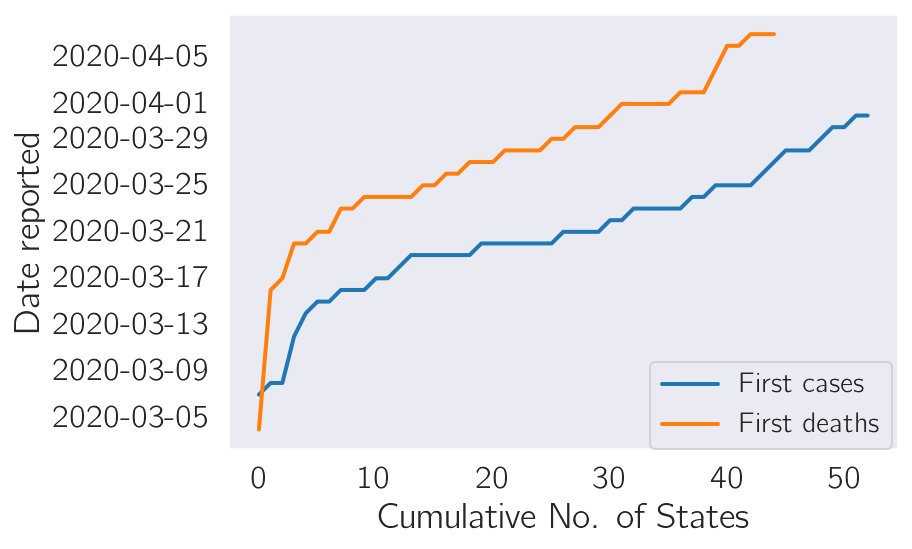

In [3]:
cv.get_first(df, 'cases', 100)
cv.get_first(df, 'deaths', 10)
plt.legend(loc=(0.63,0))
plt.xlabel('Cumulative No. of States')
_ = plt.ylabel('Date reported')

## Fitting exponential growth models to cases and deaths

Next, we are going to plot the number of cases through time, starting when there are 100 cases per state.
For each state, we will fit a model

$$
    Cases = a + b \cdot e^{t / \tau}.
$$

This model will allow us to extract a parameter $\tau$ which we will use to calculate the viral reproductive number, $R_0$. The other two parameters ($a$ and $b$) will help us get stability of fit and we will not consider them further.

To assess model fit, we will overlay the model along with each curve. In the plots below, the models are plotted as dashed lines, whereas the state data is shown in colored, thick solid lines. Since the infection was quite young at the time this data was collected, the models fit strikingly well in most cases. In a couple of cases, it's clear that there are deviations from the model, but the deviations tend to disappear as the number of cases grow (which is expected for an uncontrolled epidemic where testing is occurring at a reasonable rate).

I have limited the data to those states that have registered at least 100 cases to remove noise from poor sampling.

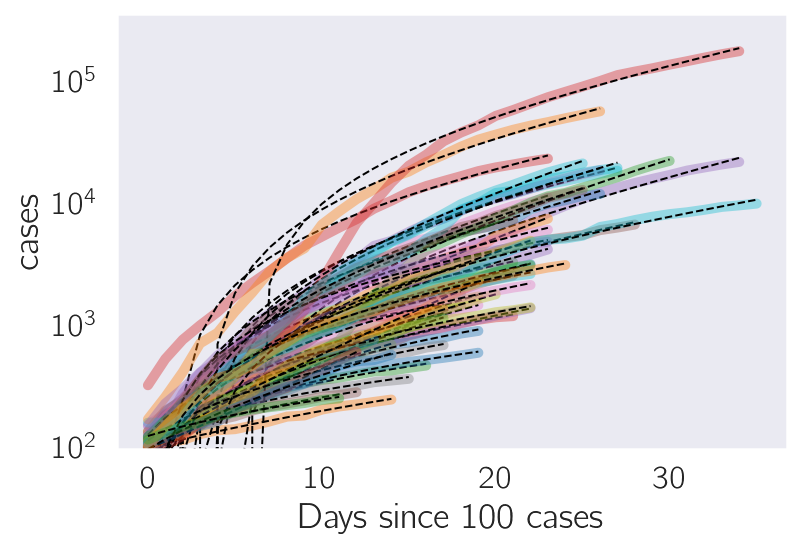

In [4]:
tau_cases, cov_cases = cv.plot_time(df, 'cases', alpha=0.4)

We can repeat the above exercise using number of deaths instead of cases. Both datasets should give identical results if the data is trustworthy. Here, we align the curves by the number of days since 100 cases, keeping only those states that have data for 6 days since their first death.

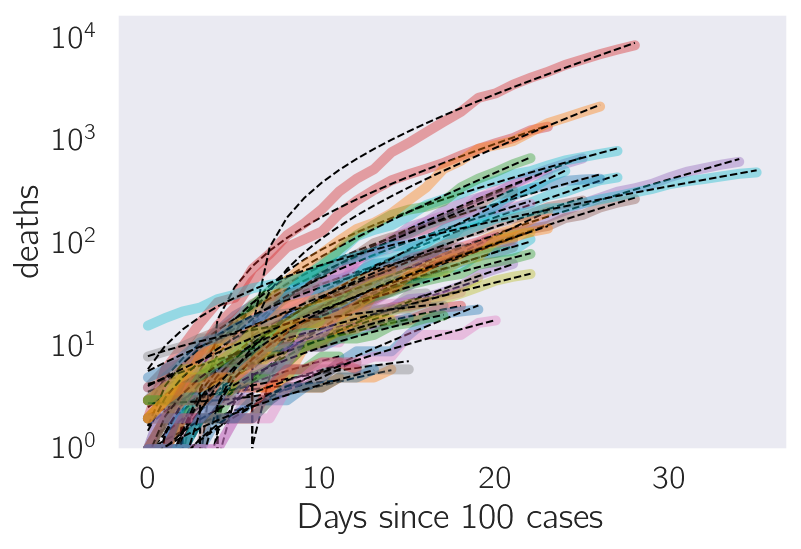

In [5]:
tau_deaths, cov_deaths = cv.plot_time(df, 'deaths', alpha=0.4, ymin=1)

## Estimating $R_0$, the viral reproductive number

Having fit the exponential model to two different datasets per state, we can plot the $\tau$ parameters fit to the number of cases and number of deaths per state on a scatter plot. Since the $\tau$ parameters for both curves should be the same, and if we expect that all states should have the same $\tau$ parameter on average, then the scatter plot should show all state $(\tau_{cases}, \tau_{deaths})$ clustering symmetrically around a central point, $\tau_{average}, \tau_{average}$.

Of course, the US has had significant problems with testing, and some states are still in the early days of the pandemic, so fluctuations in parameters are to be expected. We can visualize poorly fit parameters by changing the point size to be inversely proportional to the root mean square error of the state measurements, $\sqrt{\sigma^2_{cases} + \sigma^2_{deaths}}$, where $\sigma$ is the standard error associated with each parameter. The smaller the point on the plot, the less certainty we should have about its location.

The plot below shows some interesting point distributions. A set of large points is clustering in the lower left corner, suggesting $\tau \sim 7$ on average. Next, there is a long tail extending along $\tau_{cases} > 10$, and point size decreases as $\tau_{cases}$ gets larger. However, for most states with $\tau_{cases} > 10$, $\tau_{deaths}$ remains clustered around 7, suggesting that these states are having serious difficulties testing cases. This long tail therefore likely represents states that are not testing enough, but which have enough deaths to accurately estimate the growth rate of their epidemics. These states have a more serious problem than the number of cases and their growth rates suggest.

Next, there's a couple of states that have much larger $\tau_{cases}$ AND $\tau_{deaths}$ than the others, but which also have high model fit errors. These states are likely at the beginning of their epidemic and need more data. My bet is that they would regress towards the mean as their case rate increases if they do not institute social distancing measures (they will).

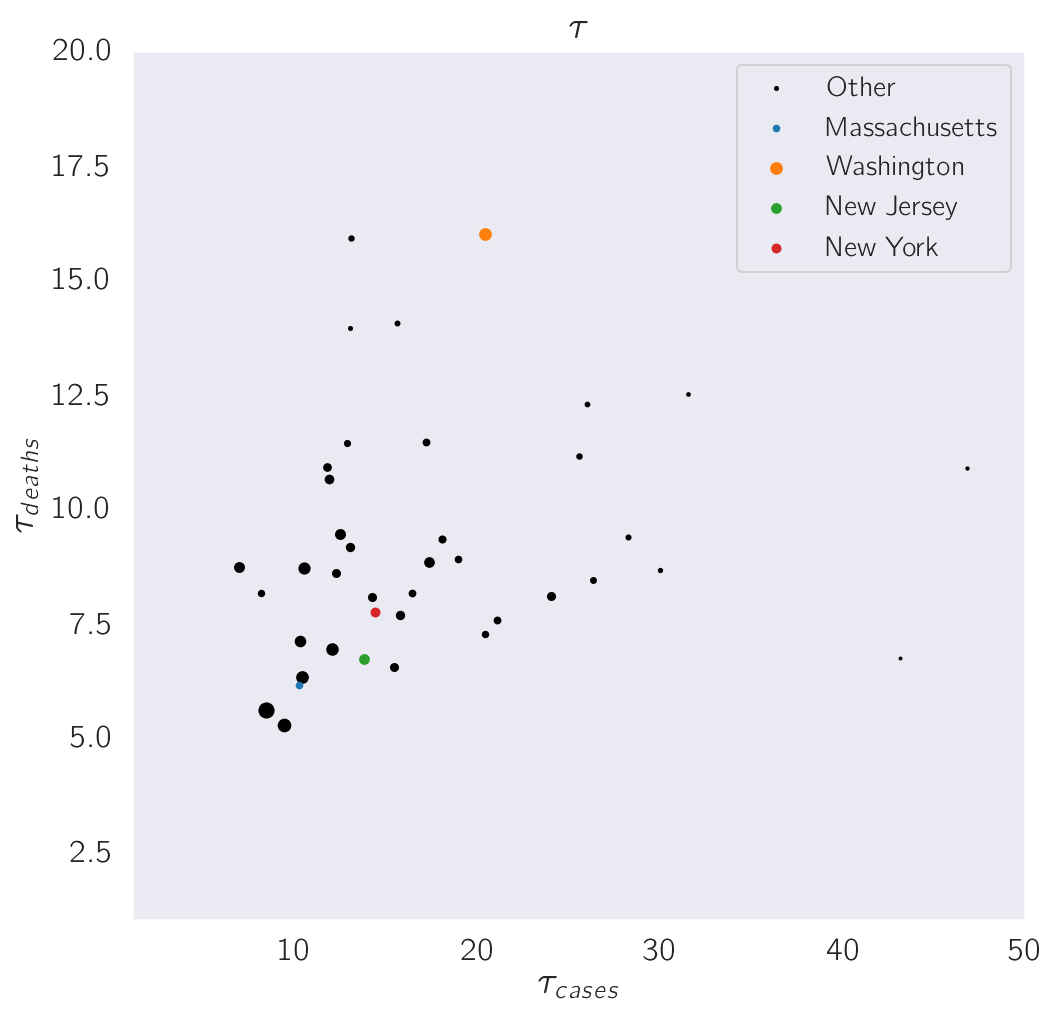

In [6]:
cv.plot_params(lambda x: x, tau_cases, tau_deaths, cov_cases, cov_deaths)
plt.ylim(1, 20)
plt.xlim(1, 50)
# plt.yscale('log')
# plt.xscale('log')
plt.title(r'$\tau$')
plt.xlabel(r'$\tau_{cases}$')
_ = plt.ylabel(r'$\tau_{deaths}$')

Next, we will transform the model parameter, $\tau$, to calculate the viral reproductive number, $R_0$. The viral reproductive number is the average number of transmission events an infectious individual will carry out at the beginning of the epidemic in the absence of any countermeasures. To calculate $R_0$, we will use the relationship:

$$
R_0 = 1 + \frac{1}{\gamma\tau}.
$$

The equation above requires us to estimate one more parameter, $\gamma$. $\gamma$ is the inverse of the average infectious period. For COVID19, the infectious period seems to me on the order of two weeks. Therefore, we set $\gamma \sim 1/14~days^{-1}$.

Once again, in the plot below notice that the smallest points *systematically have lower $R_0$ values* and would therefore tend to under-estimate the severity of their outbreaks in the absence of external information or improved testing regimes (incidentally, this shows the importance of a unified federal response to epidemics). 

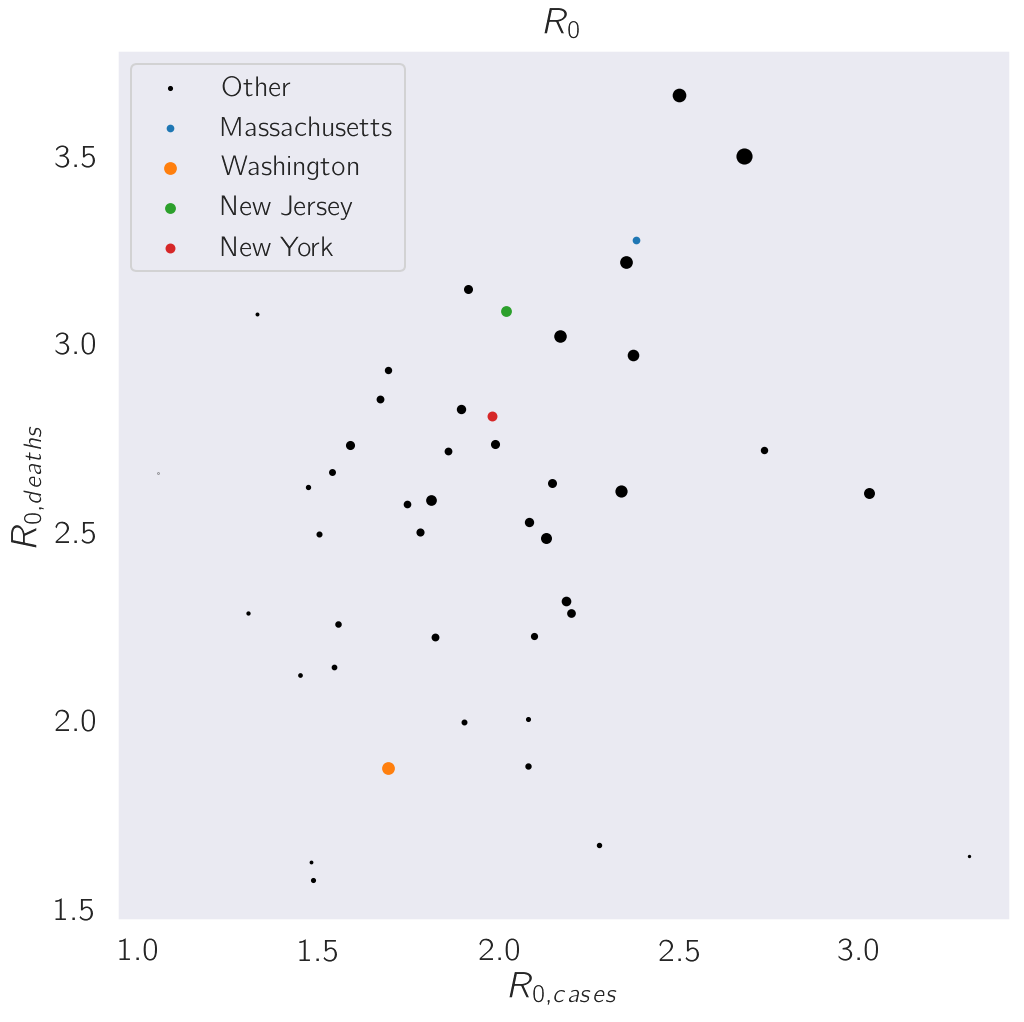

In [7]:
def r0(tau, gamma = 1/14):
    """The relationship between tau and R_0"""
    return 1 + 1 / (tau * gamma)

cv.plot_params(r0, tau_cases, tau_deaths, cov_cases, cov_deaths)
plt.xlabel(r'$R_{0,cases}$')
plt.ylabel(r'$R_{0,deaths}$')
_ = plt.title(r'$R_0$')

It would seem that $R_0$ estimated based on the change in cases through time is around 3. Based on deaths, R_0 would appear to be closer to 4. The average of both measurements suggests the true $R_0$ in the absence of social distancing is probably close to 3.5, which agrees with currently published estimates. This virus is quite infectious!

## Doubling times

Since we (still!) are at the beginning of the epidemic, the virus was growing exponentially until social distancing was put in place. As a result, we can calculate the doubling rate of an exponentially growing infection using the following equation:

$$
t_{double} = \frac{\ln{2}}{\gamma (R_0 - 1)} = \tau \ln{2}
$$

From the plot below, we can see that the doubling time estimates go are about 5 days for cases, and 3.5ish days for deaths. My gut feeling is that the death data is more accurate than the case data. Maybe we can agree on a 4 day doubling rate in the absence of social distancing measures and at the beginning of the epidemic? 

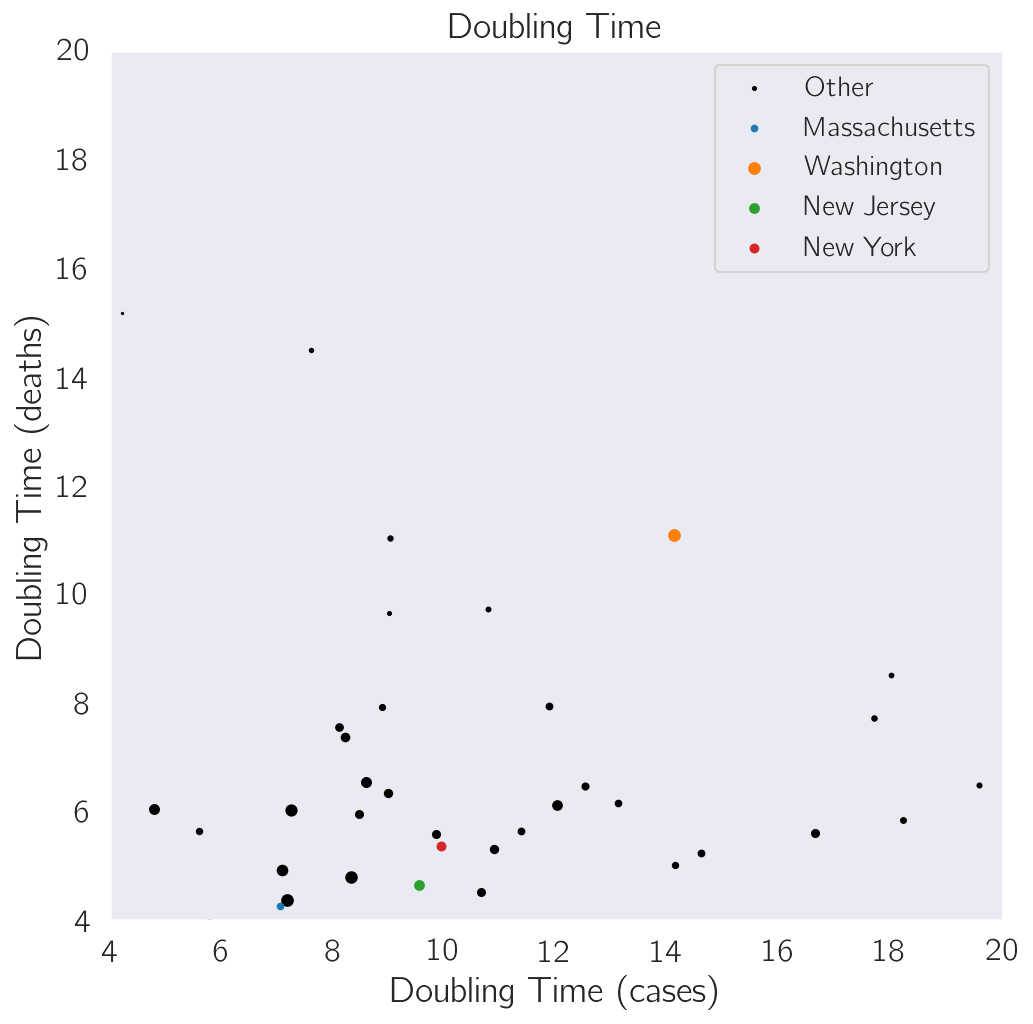

In [11]:
cv.plot_params(lambda x: x * np.log(2), tau_cases, tau_deaths, cov_cases, cov_deaths)
plt.xlim(4, 20)
plt.ylim(4, 20)
plt.title('Doubling Time')
plt.xlabel('Doubling Time (cases)')
_ = plt.ylabel('Doubling Time (deaths)')

# Case Fatality Rate

Let's take a step back, and plot the number of cases reported versus the number of deaths for each state. This will give us an idea about the case fatality rate per state through time. In the plot below, we will see that most states are reporting a CFR around 1-2%, which is probably an over-estimate. The best measurements suggest a mortality rate of about 1% overall.

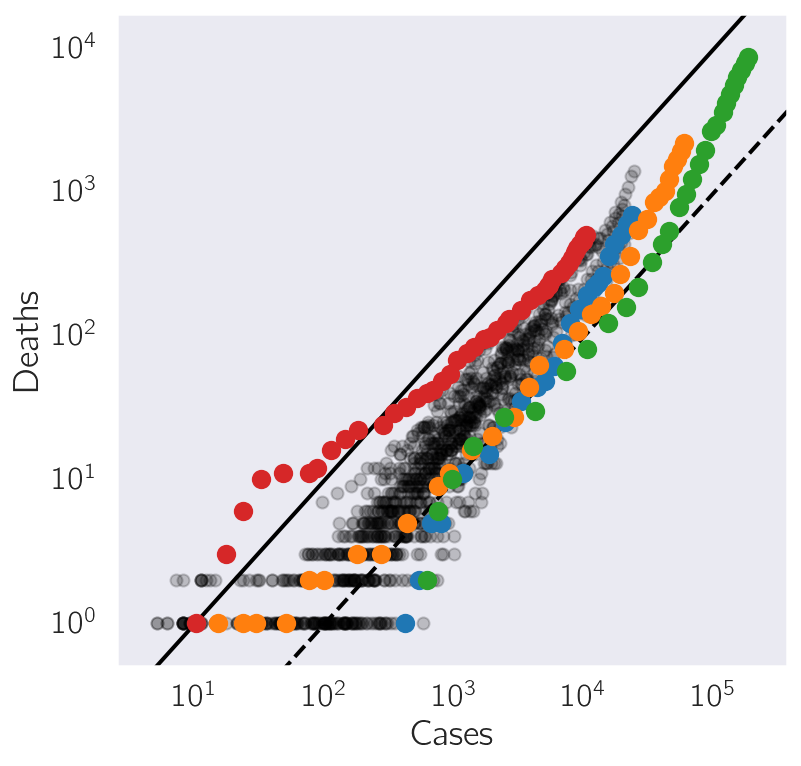

In [9]:
cv.plot_cases_vs_deaths(df)

Another way to look at the data is to plot the Case Fatality Rate (Deaths / Total Cases) against the number of cases. This is an easier way to observe how mortality is changign through time. It reveals that Washington was hit hard by by the virus initially (it landed in a home for the elderly, who are particularly vulnerable to the virus) but that mortality in that state has gone down as the virus infects a more representative sample of the population. On the other hand, the mortality estimates for Massachusetts, New Jersey and Washington are all increasing as the number of cases increases. Why this is appears unclear. Maybe the virus is more dangerous than previous estimates believed, or maybe the virus is circulating among at-risk populations (elderly, diabetic, hypertense and low-socioeconomy). Yet another hypothesis is that as the medical system is overloaded, the CFR increases as a result of poorer medical care. Which one of these hypotheses is correct (if any) or if all of them are reflected in this data will likely be the subject of much research in the future. 

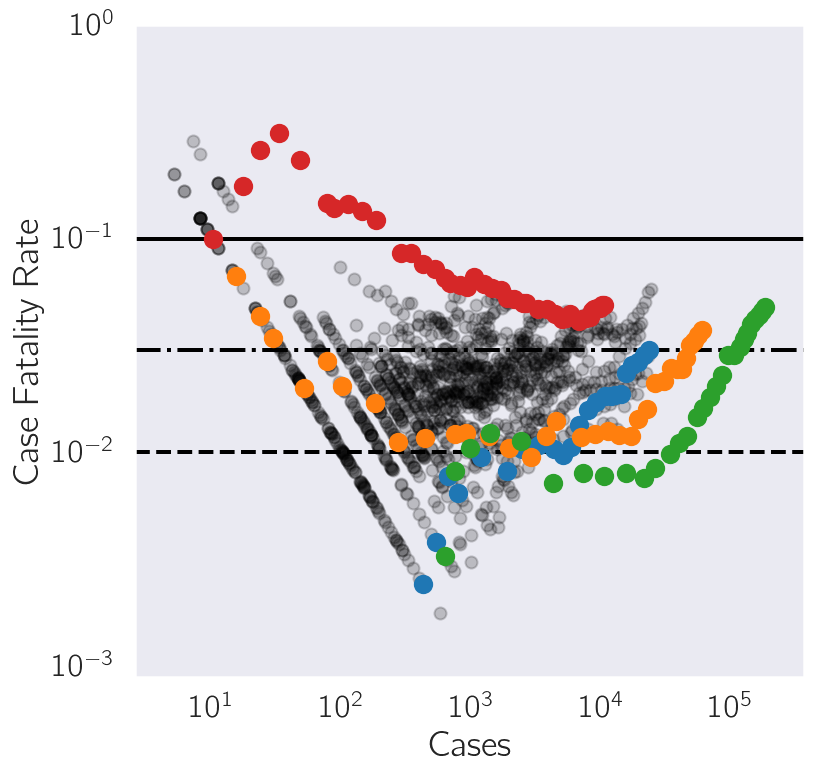

In [10]:
cv.plot_cases_vs_deaths(df, CFR=True)

# Putting it all together

So far, we have learned that $R_0 ~ 3.5$ for SARS-Cov-2, we have learned the doubling time of the virus is 4 days, and we have learned that the mortality rate is around 1%. We have also learned that at the time of first detection, a reasonable guess for the time the virus has been in circulation in a state is at least 10 days. What can we do with this information? 

Consider the case where a state observes its first death from the virus. Since the mortality rate from this virus appears to be close to 1%, it follows that to observe a single death, there had to be 100 infected individuals who were infected simultaneously to the patient who passed away. Since our latest guess for when the virus was introduced to the state would be ~20 days prior to the first death, it follows that in the absence of social distancing measurements there have been 5 doublings. Thus, a first-pass guess for the number of infections in a state that has observed a single death would be $100 \cdot 2^5 = 3,200$ cases! This highlights the need to **immediately implement strong social distancing measurements and containment protocols upon observation of a community death**. Because SARS-Cov-2 is a relatively slow killer relative to its doubling rate, observation of a single community death is likely indicative of significant community level transmission.

Note: The inference changes if the first death is known or strongly suspected to be the result of travel from an infected region (hence the use of the term `community death`), since this affects the number of days we would assume the virus has been in circulation in the community. 

My favorite source of information for COVID19 epidemiology is nexstrain.org, and if you enjoyed this analysis, I strongly suggest reading their information. It is far more relevant, accurate and up-to-date than anything I can hope to achieve here.

Stay safe, stay healthy and socially distanced!